In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_sparse_signal(input_image_batch, signal_points=2, linear=False):
    # Take as input a torch tensor in form [batch_size, 1, x_dim, y_dim]]
    # Create a copy of the input image batch
    image_batch = input_image_batch.clone()

    # Flatten the image tensor
    flat_batch = image_batch.view(image_batch.size(0), -1)

    # Count the number of non-zero values in each image
    nz_counts = torch.sum(flat_batch != 0, dim=1)

    # Find the indices of the images that have more non-zero values than signal_points
    sparse_indices = torch.where(nz_counts > signal_points)[0]

    # For each sparse image, randomly select signal_points non-zero values to keep
    for idx in sparse_indices:
        # Find the indices of the non-zero values in the flattened image
        nz_indices = torch.nonzero(flat_batch[idx]).squeeze()

        # Randomly select signal_points non-zero values to keep
        if linear:
            kept_indices = torch.linspace(0, nz_indices.numel() - 1, steps=signal_points).long()
        else:
            kept_indices = torch.randperm(nz_indices.numel())[:signal_points]

        # Zero out all non-selected values
        nonkept_indices = nz_indices[~torch.isin(nz_indices, nz_indices[kept_indices])]
        flat_batch[idx, nonkept_indices] = 0

    # Reshape the flat tensor back into the original shape
    output_image_batch = flat_batch.view_as(image_batch)

    return output_image_batch

def simulate_detector_resolution(input_image_batch, x_std_dev, y_std_dev, tof_std_dev, plot=False):
    """
    Improve this so it takes pysical values rather than indicies and also so that it uses gaussian to draw randoms from 
    
    """
    # Take as input a torch tensor in form [batch_size, 1, x_dim, y_dim]]
    # Create a copy of the input image batch
    image_batch_all = input_image_batch.clone()

    for idx, image_batch_andc in enumerate(image_batch_all):
        image_batch = image_batch_andc.squeeze()
        # Assume that the S2 image is stored in a variable called "image_tensor"
        x, y = image_batch.size()

        # For all the values in the tensor that are non zero (all signal points) adda random value drawn from a gaussian distribution with mean of the original value and std dev of ToF_std_dev so simulate ToF resoloution limiting
        image_batch[image_batch != 0] = image_batch[image_batch != 0] + torch.normal(mean=0, std=tof_std_dev, size=image_batch[image_batch != 0].shape)

        # Generate random values for shifting the x and y indices
        x_shift = torch.normal(mean=0, std=x_std_dev, size=(x, y), dtype=torch.float32)
        y_shift = torch.normal(mean=0, std=y_std_dev, size=(x, y), dtype=torch.float32)

        # Create a mask for selecting non-zero values in the image tensor
        mask = image_batch != 0

        # Apply the x and y shifts to the non-zero pixel locations
        new_x_indices = torch.clamp(torch.round(torch.arange(x).unsqueeze(1) + x_shift), 0, x - 1).long()
        new_y_indices = torch.clamp(torch.round(torch.arange(y).unsqueeze(0) + y_shift), 0, y - 1).long()
        shifted_image_tensor = torch.zeros_like(image_batch)
        shifted_image_tensor[new_x_indices[mask], new_y_indices[mask]] = image_batch[mask]

        if plot:
            plt.imshow(shifted_image_tensor, cmap='gray', vmin=0, vmax=100)
            plt.title('S')
            plt.show()

        image_batch_all[idx,0] = shifted_image_tensor
        
    return image_batch_all

# Function to add n noise points to each image in a tensor batch 
def add_noise_points_to_batch_prenorm(input_image_batch, noise_points=100, time_dimension=100):
    image_batch = input_image_batch.clone()
    if noise_points > 0:
        #Find dimensions of input image 
        x_dim = image_batch.shape[2]
        y_dim = image_batch.shape[3]

        #For each image in the batch
        for image in image_batch:

            # Create a list of unique random x and y coordinates
            num_pixels = x_dim * y_dim
            all_coords = np.arange(num_pixels)
            selected_coords = np.random.choice(all_coords, noise_points, replace=False)
            x_coords, y_coords = np.unravel_index(selected_coords, (x_dim, y_dim))
            
            # Iterate through noise_points number of random pixels to noise
            for i in range(noise_points):

                # Add a random number between recon_threshold and 1 to the pixel 
                image[0][x_coords[i], y_coords[i]] = np.random.uniform(0, time_dimension)

    return image_batch

In [10]:
x_std_dev = 1
y_std_dev = 1
tof_std_dev = 20

signal_points = 100
noise_points = 100

time_dimension = 100
batch_size = 10 # Repeat the tensor `batch_size` times along the first dimension to create a batch of tensors



# Load numpy array from disk
arr = np.load("N:\Flat SimpleX-128x88-1 Crosses, No0.npy")
image_tensor = torch.from_numpy(arr)

# Add an extra dimension to the tensor to make it of shape `(C, x, y)`
image_tensor = image_tensor.unsqueeze(0)
clean_input_batch = image_tensor.repeat(batch_size, 1, 1, 1)

In [11]:
# Call the create_sparse_signal function to get the sparse output tensor
sparse_output_batch = create_sparse_signal(clean_input_batch, signal_points)
sparse_and_resolution_limited_batch = simulate_detector_resolution(sparse_output_batch, x_std_dev, y_std_dev, tof_std_dev)
noised_sparse_reslimited_batch = add_noise_points_to_batch_prenorm(sparse_and_resolution_limited_batch, noise_points, time_dimension)


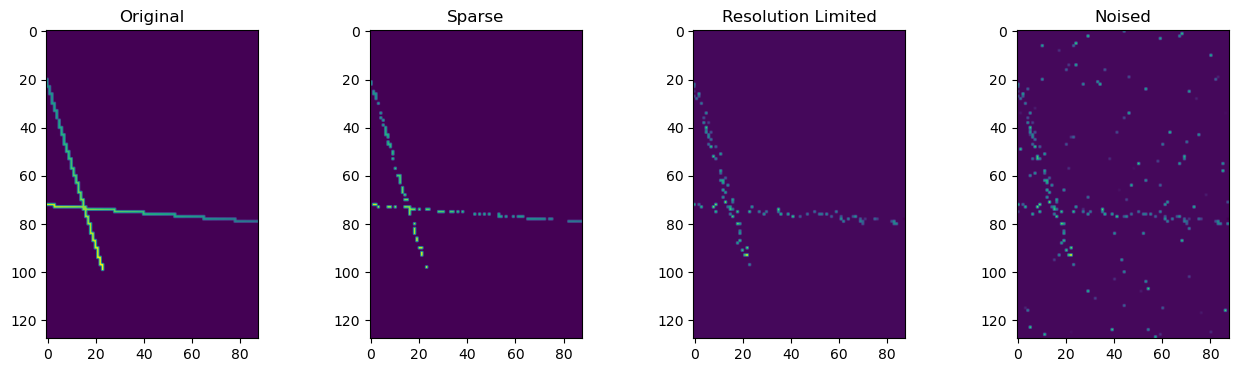

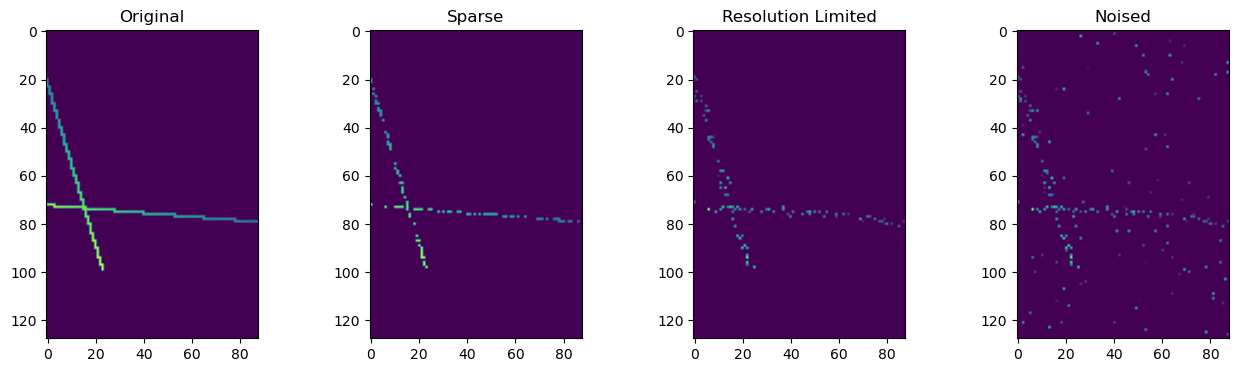

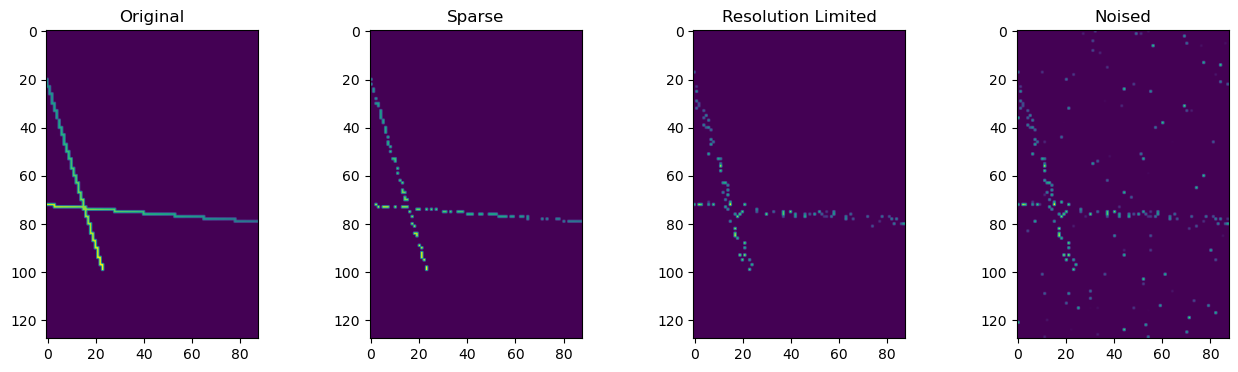

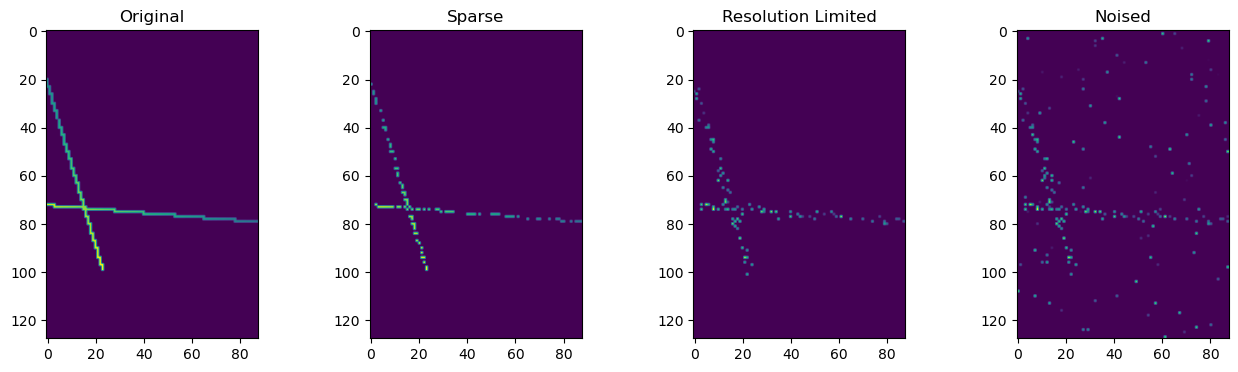

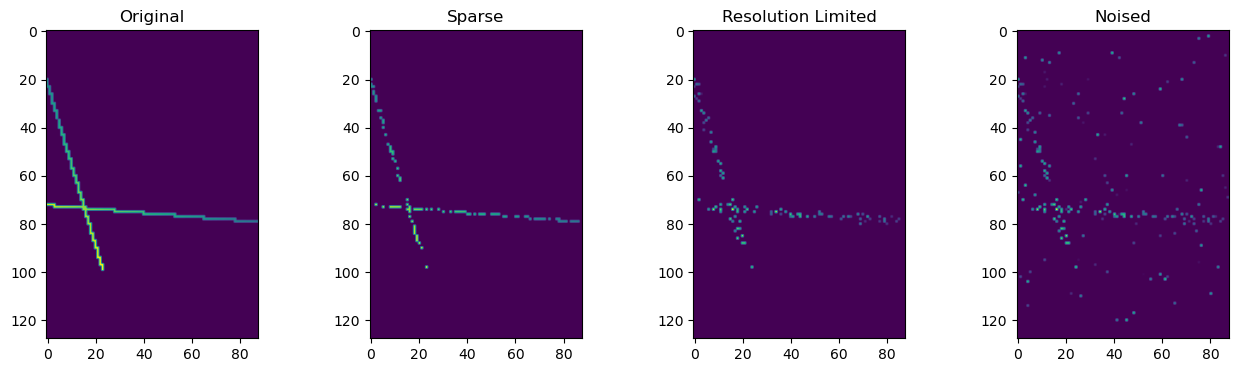

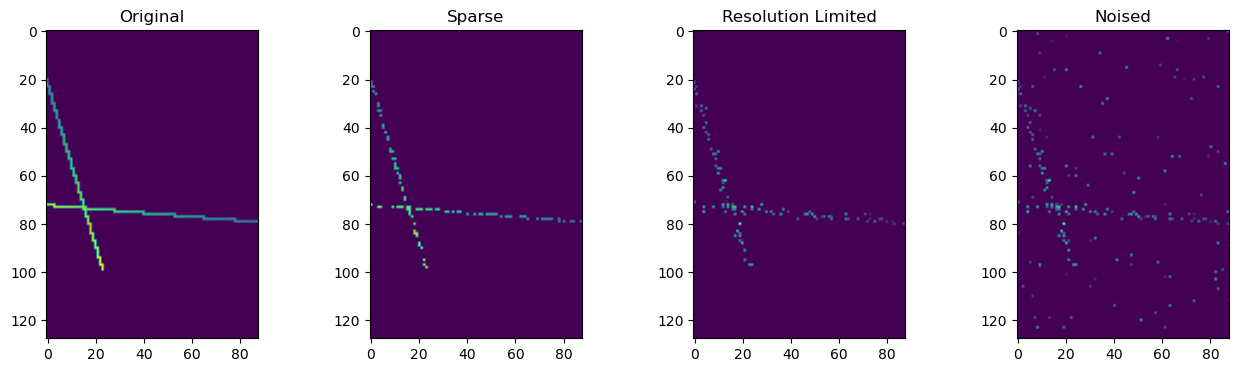

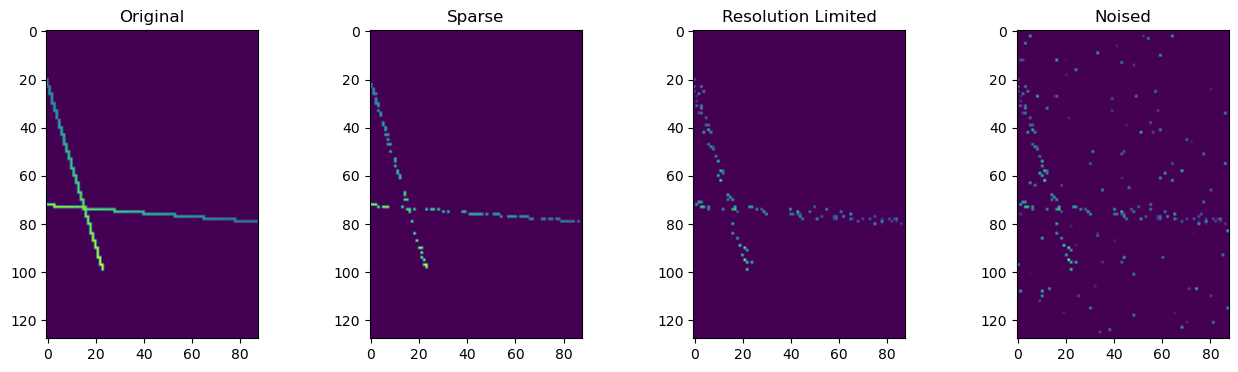

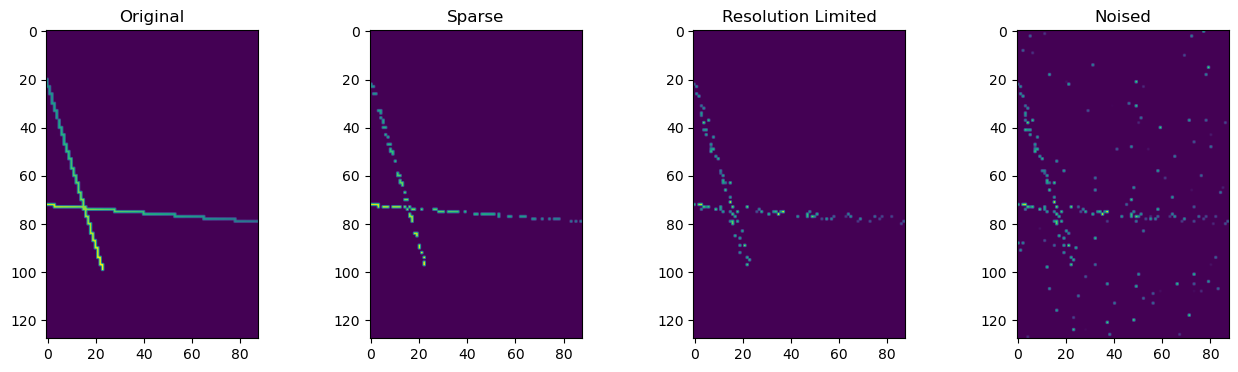

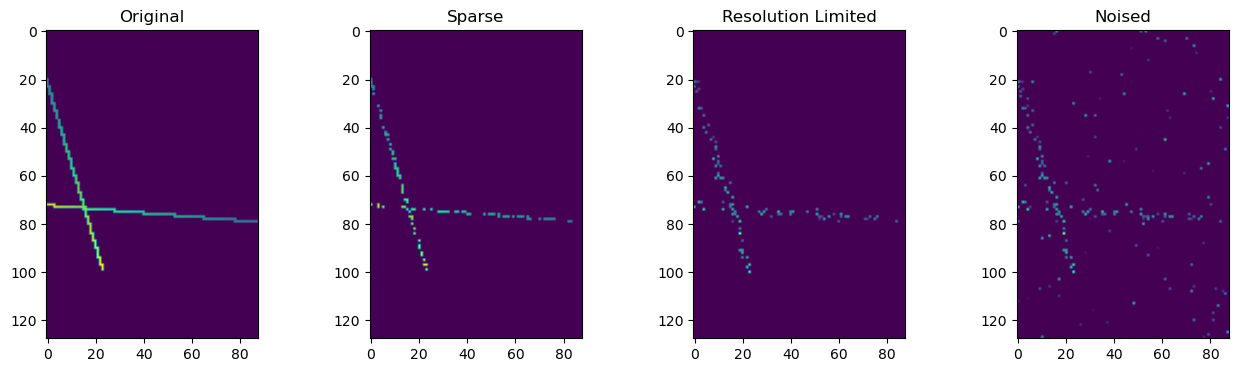

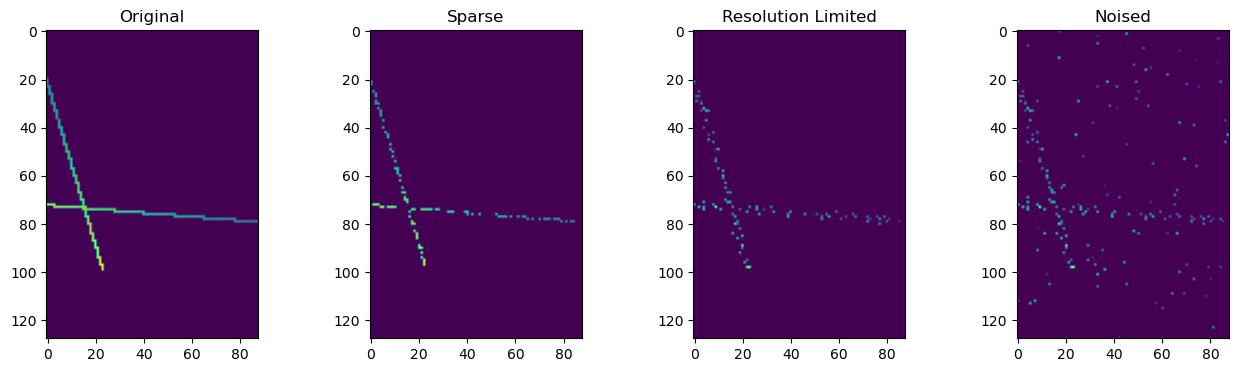

In [20]:
# Loop through each image in the batch and plot the original and sparse versions side by side
for i in range(clean_input_batch.size(0)):
    # Get the i-th image from the input batch and sparse output batch
    input_image = clean_input_batch[i, 0]
    sparse_output_image = sparse_output_batch[i, 0]
    sparse_rl_image = sparse_and_resolution_limited_batch[i, 0]
    noised_sparse_rl_image = noised_sparse_reslimited_batch[i, 0]

    # Create a 1x4 grid of subplots for the original and resulting images
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

    # Plot the original image on the left subplot
    ax[0].imshow(input_image, cmap='viridis')
    ax[0].set_title('Original')

    # Plot the sparse output image on the right subplot
    ax[1].imshow(sparse_output_image, cmap='viridis')
    ax[1].set_title('Sparse')
    
    # Plot the sparse output image on the right subplot
    ax[2].imshow(sparse_rl_image, cmap='viridis')
    ax[2].set_title('Resolution Limited')
    
    # Plot the sparse output image on the right subplot
    ax[3].imshow(noised_sparse_rl_image, cmap='viridis')
    ax[3].set_title('Noised')
    
    # Show the plot
    plt.show()
    

In [6]:
plt.imshow()

TypeError: imshow() missing 1 required positional argument: 'X'